Step 1 - Import python libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.options.mode.chained_assignment = None

Step 2 - Load and read your data file
- pyTCR accepts a single `.tsv` file that should contain all the samples.
  - The following cell attempts to detect whether you are running the notebook in a Google Colab cloud environment or in a local environment, and then loads the data at the specified path.
- The `filePath` variable in the following code cell should be changed to the location of your file. The following options are supported:
  1. A `filePath` from Google Drive (to run on a cloud environment)
  2. A `filePath` from your local computer (to run on a local environment, other cloud environments should work as expected)
- The `data_adapter` notebook can be used to convert the data into the correct format for pyTCR to read.

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

df.head()

,sample,frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,age,gender,...,icu_admit,birth_year,blood_type,cmv_at_donation,days_from_last_symptom_to_sample,ethnicity,height_meters,hospitalized,weight_kg,race
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian


Step 3 - Create the standardized format (column content and column names)

- Sample name (sample)
- Clone frequency (freq)
- Clone reads count (#count)
- CDR3 amino acid clonotype (cdr3aa)
- CDR3 nucleotide (cdr3nt)
- V gene (v)
- D gene (d)
- J gene (j)
- Optional fields (here we use hospitalization as the clinical feature)

In [3]:
# Select the columns that are listed above
df = df[['sample','frequency', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', 'freq' , '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

df.head()

,sample,freq,#count,cdr3aa,cdr3nt,v,d,j,hospitalized
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True


In [4]:
df['aa_length'] = df['cdr3aa'].str.len()

df_aa_spectratype = df.groupby(['sample', 'hospitalized', 'aa_length'], as_index=False)[
    'freq'].agg({'spectratype': 'sum'})

In [6]:
df_aa_max_spectratype = df_aa_spectratype.loc[df_aa_spectratype.groupby('sample')[
    'spectratype'].idxmax()]

Amino acid motif count

In [7]:
# Define the function to count amino acid motifs (k is the length of the motif)
def aamotif(k, aa_list):
    aamotifCount = {}
    for aa in aa_list:
        for i in range(len(aa)-k+1):
            aamotif = aa[i:i+k]
            aamotifCount[aamotif] = aamotifCount.get(aamotif, 0)+1
    return aamotifCount

# Create an empty dataframe for storing results
df_aa_motif = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    # Use amino acid motif length of 6 as an example
    df_temp = aamotif(6, df_temp['cdr3aa'])
    df_temp = pd.DataFrame(df_temp.items(), columns=['motif', 'count'])
    df_temp['sample'] = sample

    # Append the dataframe based on amino acid motifs and stores in the result dataframe
    df_aa_motif = df_aa_motif.append(df_temp, ignore_index=True)

    # Add the hospitalization information as a column
    df_aa_motif_1 = df_aa_motif.merge(
        df_aa_max_spectratype[['sample', 'hospitalized']], on='sample')

df_aa_motif_1

,motif,count,sample,hospitalized
0,CASSLL,2969,1566622BW_TCRB,False
1,ASSLLA,539,1566622BW_TCRB,False
2,SSLLAG,382,1566622BW_TCRB,False
3,SLLAGE,24,1566622BW_TCRB,False
4,LLAGET,10,1566622BW_TCRB,False
...,...,...,...,...
38430039,EGRVYY,1,989003BW_TCRB,True
38430040,GRVYYG,1,989003BW_TCRB,True
38430041,RVYYGC,1,989003BW_TCRB,True
38430042,VYYGCT,1,989003BW_TCRB,True


## FigureS7a

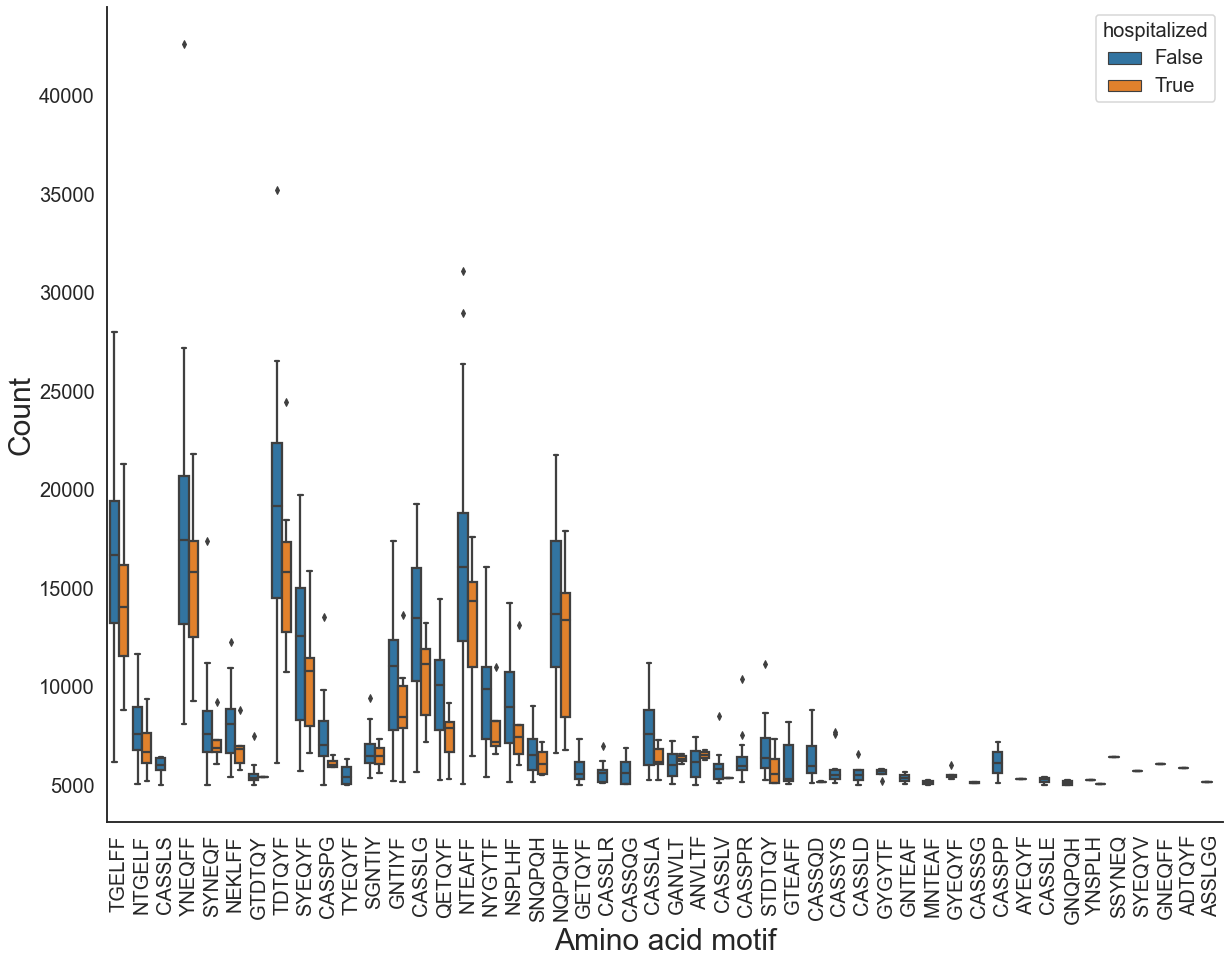

In [8]:
# Remove motif counts that are less than 4999
df_aa_motif_1 = df_aa_motif_1[df_aa_motif_1['count'] > 5000]

attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(20,15))

ax = sns.boxplot(data=df_aa_motif_1, x='motif',
                 y='count', hue=attribute)

ax.set_xlabel('Amino acid motif', fontsize=30)
ax.set_ylabel('Count', fontsize=30)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='20')
sns.despine()

plt.savefig("../figures/supplementary/figureS7a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS7a.png",bbox_inches="tight")

plt.show()

Nucleotide sequence motif count

In [9]:
# Define the function to count nucleotide motifs (k is the length of the motif)
def ntmotif(k, nt_list):
    ntmotifCount = {}
    for nt in nt_list:
        for i in range(len(nt)-k+1):
            ntmotif = nt[i:i+k]
            ntmotifCount[ntmotif] = ntmotifCount.get(ntmotif, 0)+1
    return ntmotifCount

# Create an empty dataframe for storing results
df_nt_motif = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    # Use amino acid motif length of 6 as an example
    df_temp = ntmotif(6, df_temp['cdr3nt'])
    df_temp = pd.DataFrame(df_temp.items(), columns=['motif', 'count'])
    df_temp['sample'] = sample

    # Append the dataframe based on amino acid motifs and stores in the result dataframe
    df_nt_motif = df_nt_motif.append(df_temp, ignore_index=True)

    # Add the hospitalization information as a column
    df_nt_motif_1 = df_nt_motif.merge(
        df_aa_max_spectratype[['sample', 'hospitalized']], on='sample')

df_nt_motif_1

,motif,count,sample,hospitalized
0,GCGTCT,2641,1566622BW_TCRB,False
1,CGTCTG,2252,1566622BW_TCRB,False
2,GTCTGC,9503,1566622BW_TCRB,False
3,TCTGCT,19231,1566622BW_TCRB,False
4,CTGCTG,19331,1566622BW_TCRB,False
...,...,...,...,...
197985,NNCTCC,1,989003BW_TCRB,True
197986,NCTCCA,1,989003BW_TCRB,True
197987,NNNTCA,1,989003BW_TCRB,True
197988,NNTGTG,1,989003BW_TCRB,True


## FigureS7b

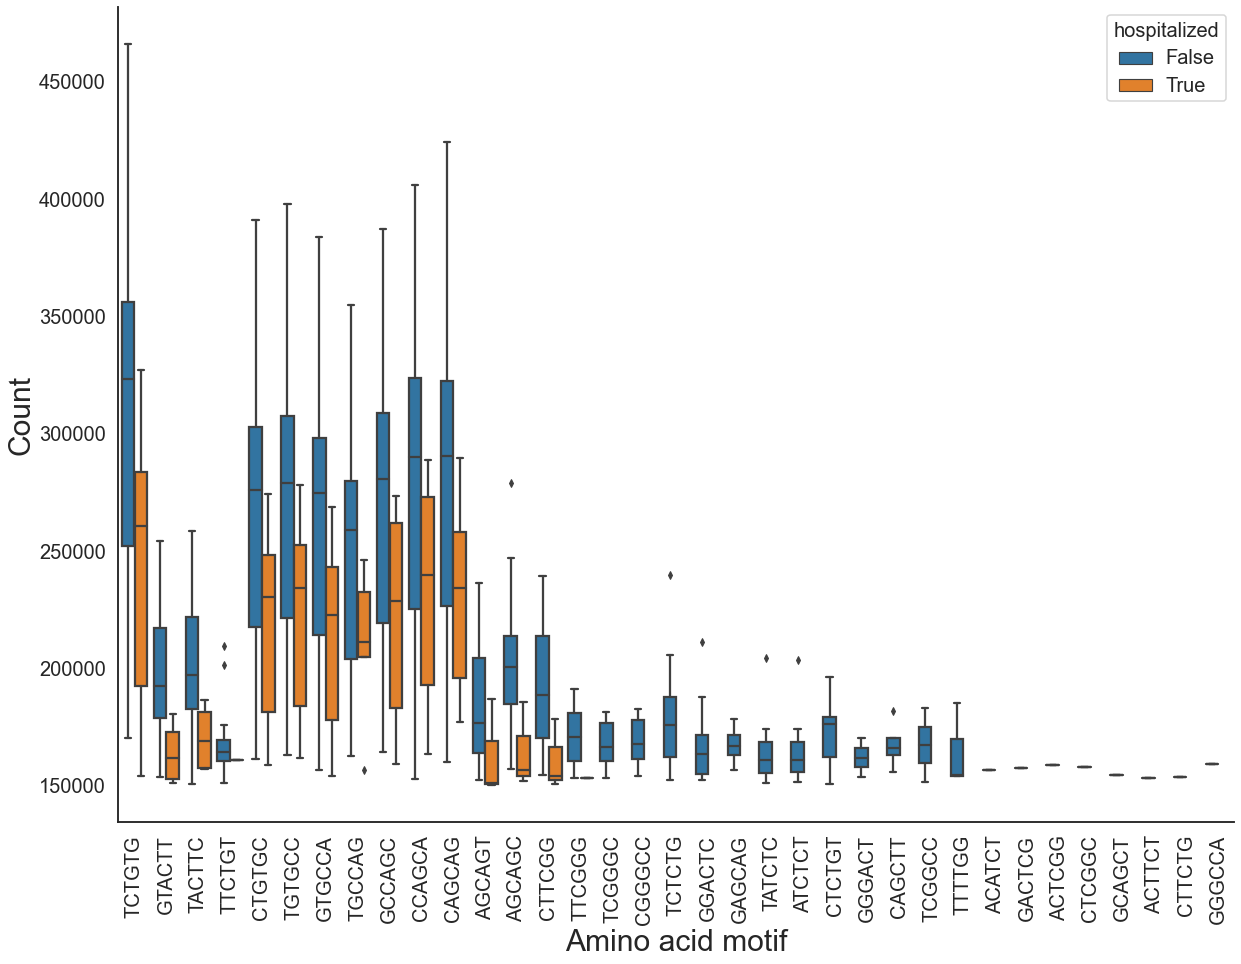

In [10]:
# Remove motif counts that are less than 150000
df_nt_motif_1 = df_nt_motif_1[df_nt_motif_1['count'] > 149999]

attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(20,15))

ax = sns.boxplot(data=df_nt_motif_1, x='motif',
                 y='count', hue=attribute)

ax.set_xlabel('Amino acid motif', fontsize=30)
ax.set_ylabel('Count', fontsize=30)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='20')
sns.despine()

plt.savefig("../figures/supplementary/figureS7b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS7b.png",bbox_inches="tight")

plt.show()